In [3]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Fáza 2 - Predspracovanie údajov

## 2.1 Realizácia predspracovania dát

### A - Rozdelenia dát na trénovaciu a testovaciu množinu

#### zlúčime potrebné dáta do jedného datasetu 

In [5]:
# loading datasets
df_processes    = pd.read_csv("processes.csv", sep='\t')
df_connections  = pd.read_csv("connections.csv", sep='\t')

#### vyberieme si dáta, ktoré sme identifikovali v EDA

In [6]:
df_processes    = df_processes[["imei", "ts", "mwra", "p.android.gm", "p.android.documentsui", "p.system", "p.android.externalstorage", "p.android.settings", "p.android.chrome"]]
df_connections  = df_connections[["imei", "ts", "mwra", "c.katana", "c.dogalize", "c.android.chrome", "c.android.gm"]]

#### spojíme ich pomocou "ts" a "imei"

In [7]:
df = df_connections.merge(df_processes, on=['imei', 'ts'], how='outer')

#### Rozdelíme dáta v pomere 80:20 (trénovacia/testovacia množina). Tento pomer vychádza z predpokladu, že pri dostatočne veľkom množstve dát, máme pri rozdelení dostatok dát na trénovanie a efektívne učenie modelu, zatiaľ čo testovacia množina bude dostatočne veľká pre overenie modelu. Tento pomer je bežný a vhodný pre väčšinu úloh strojového učenia.

In [8]:
TRAIN = 0.8

train_df, test_df = train_test_split(df, train_size=TRAIN, random_state=42)

train_df.head()

,imei,ts,mwra_x,c.katana,c.dogalize,c.android.chrome,c.android.gm,mwra_y,p.android.gm,p.android.documentsui,p.system,p.android.externalstorage,p.android.settings,p.android.chrome
4229,863033069630348354,2018-05-07 06:23:00,1.0,8.78526,12.97475,11.62351,14.41864,1.0,9.23972,10.43492,13.82551,9.86109,8.95921,11.39909
12572,8630330696303481545,2018-05-11 14:57:00,1.0,11.81607,14.66263,10.73155,14.21554,1.0,10.37842,10.42450,14.23429,14.15057,9.07541,11.87810
12930,8630330696303481669,2018-05-06 20:06:00,0.0,12.49268,13.38094,10.93373,14.18849,0.0,11.95766,6.47040,12.71239,9.86456,7.39561,10.22850
14497,8630330696303482196,2018-05-10 16:15:00,1.0,12.27976,13.40483,9.23485,15.58463,1.0,8.52524,13.52572,13.66325,10.38706,9.61267,9.97641
1347,359043379931766437,2018-05-14 23:22:00,0.0,13.17060,14.34610,9.63767,6.44279,0.0,12.37160,12.12072,13.74927,11.34104,9.44807,5.71597


#### ďalej pracujeme s trénovacím datasetom

## B - Transformujeme dáta na vhodný formát pre ML

In [9]:
# better info()
def analyze_dataframe(the_df):
    table = pd.DataFrame({
        'Missing Values': the_df.isnull().sum(),
        'Data Type': the_df.dtypes
    })

    rows, columns = the_df.shape
    duplicates = the_df.duplicated().sum()

    print(f"Shape: {rows} rows, {columns} columns")
    print(f"Duplicates: {duplicates}")

    display(table)
    
analyze_dataframe(train_df)

Shape: 12331 rows, 14 columns
Duplicates: 378


,Missing Values,Data Type
imei,0,int64
ts,0,object
mwra_x,0,float64
c.katana,0,float64
c.dogalize,0,float64
c.android.chrome,0,float64
c.android.gm,0,float64
mwra_y,0,float64
p.android.gm,0,float64
p.android.documentsui,0,float64


In [10]:
matches = (train_df['mwra_x'] == train_df['mwra_y']).sum()
not_matches = len(train_df) - matches

print(f"Matched: {matches}, Not matched: {not_matches}")

Matched: 12331, Not matched: 0


#### môžeme vymazať dáta, pomocou ktorých sme spájali datasety do jedného, t.j. nepotrebné stĺpce: ts, mrwa_y + premenujeme mwra_x na mwra

In [11]:
train_df = train_df.drop(columns=['ts', 'mwra_y'], errors='ignore')
train_df = train_df.rename(columns={'mwra_x': 'mwra'})

train_df.head()

,imei,mwra,c.katana,c.dogalize,c.android.chrome,c.android.gm,p.android.gm,p.android.documentsui,p.system,p.android.externalstorage,p.android.settings,p.android.chrome
4229,863033069630348354,1.0,8.78526,12.97475,11.62351,14.41864,9.23972,10.43492,13.82551,9.86109,8.95921,11.39909
12572,8630330696303481545,1.0,11.81607,14.66263,10.73155,14.21554,10.37842,10.42450,14.23429,14.15057,9.07541,11.87810
12930,8630330696303481669,0.0,12.49268,13.38094,10.93373,14.18849,11.95766,6.47040,12.71239,9.86456,7.39561,10.22850
14497,8630330696303482196,1.0,12.27976,13.40483,9.23485,15.58463,8.52524,13.52572,13.66325,10.38706,9.61267,9.97641
1347,359043379931766437,0.0,13.17060,14.34610,9.63767,6.44279,12.37160,12.12072,13.74927,11.34104,9.44807,5.71597


In [12]:
train_df.describe()

,imei,mwra,c.katana,c.dogalize,c.android.chrome,c.android.gm,p.android.gm,p.android.documentsui,p.system,p.android.externalstorage,p.android.settings,p.android.chrome
count,1.233100e+04,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000
mean,3.879585e+18,0.625497,10.016101,11.181063,11.023363,10.554946,9.983216,9.391937,11.163586,11.713024,9.893613,9.894593
std,3.327328e+18,0.484014,2.575195,2.654335,2.710526,2.719858,2.763540,2.365531,2.310111,2.393699,2.484082,2.569458
min,3.590434e+17,0.000000,1.384790,1.802460,1.264880,1.730240,0.000000,2.551400,3.050450,3.463510,2.010490,0.879270
25%,8.630331e+17,0.000000,8.142165,9.318645,9.125685,8.564910,8.058725,7.785910,9.436415,10.088205,8.058810,8.041820
50%,3.590434e+18,1.000000,9.860910,11.288090,11.078720,10.437770,9.873050,9.194260,11.329550,11.815800,9.817520,9.922110
75%,8.630331e+18,1.000000,11.811615,13.057150,12.950765,12.511710,11.911765,10.726015,12.900690,13.396400,11.804595,11.820470
max,8.630331e+18,1.000000,19.064650,21.522060,20.710650,20.883650,20.563610,20.220660,18.999150,20.060160,18.162090,17.910570


In [13]:
def remove_outlier(the_df, the_column):
    if the_column in ['imei', 'mwra']:
        return the_df
    
    lower_bound = the_df[the_column].quantile(0.05)
    upper_bound = the_df[the_column].quantile(0.95)

    outlier_mask = (the_df[the_column] > upper_bound) | (the_df[the_column] < lower_bound)

    the_df.loc[outlier_mask, the_column] = np.where(
        the_df.loc[outlier_mask, the_column] < lower_bound,
        lower_bound,
        upper_bound
    )
    return the_df

for column in train_df.columns:
    train_df = remove_outlier(train_df, column)

train_df.describe()


,imei,mwra,c.katana,c.dogalize,c.android.chrome,c.android.gm,p.android.gm,p.android.documentsui,p.system,p.android.externalstorage,p.android.settings,p.android.chrome
count,1.233100e+04,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000
mean,3.879585e+18,0.625497,10.013604,11.181681,11.024570,10.552272,9.992341,9.367600,11.162490,11.713670,9.899836,9.902847
std,3.327328e+18,0.484014,2.384562,2.459327,2.493326,2.518698,2.538359,2.130225,2.161509,2.216309,2.326487,2.401040
min,3.590434e+17,0.000000,6.027955,6.676590,6.556425,6.307330,5.588090,5.869540,7.264380,7.619215,5.901755,5.647485
25%,8.630331e+17,0.000000,8.142165,9.318645,9.125685,8.564910,8.058725,7.785910,9.436415,10.088205,8.058810,8.041820
50%,3.590434e+18,1.000000,9.860910,11.288090,11.078720,10.437770,9.873050,9.194260,11.329550,11.815800,9.817520,9.922110
75%,8.630331e+18,1.000000,11.811615,13.057150,12.950765,12.511710,11.911765,10.726015,12.900690,13.396400,11.804595,11.820470
max,8.630331e+18,1.000000,14.458730,15.382915,15.342235,15.108480,14.617650,13.772555,14.690100,15.494580,13.889490,13.962900


#### aplikovali sme vymazanie odľahlích hodnôt na všetky stĺpce v trénovacej množine, pričom sme použili percentyl 5 a 95, z dôvodu zachovania normálnych hodnôt, no vyradzujeme extrémne hodnoty na oboch stranách

In [14]:
def handle_missing_values(the_df):
    for column in the_df.columns:
        if the_df[column].isnull().sum() > 0:
            median_value = the_df[column].median()
            the_df[column].fillna(median_value, inplace=True)
            # df.dropna(inplace=True)
    return the_df

#### vytvorili sme funkciu na nahradenie missing values pre každý riadok

In [15]:
def normalize_data(the_df):    
    scaler = StandardScaler()
    numeric_columns = the_df.select_dtypes(include=['float64', 'int64']).columns
    the_df[numeric_columns] = scaler.fit_transform(the_df[numeric_columns])
    return the_df

#### takisto pre normalizáciu dát

In [16]:
def remove_duplicates(the_df):
    the_df = the_df.drop_duplicates()
    return the_df

#### a aj na odstránenie duplikátov, ktoré potom aplikujeme na trénovaciu množinu

In [17]:
train_df    = handle_missing_values(train_df)
train_df    = normalize_data(train_df)
train_df    = remove_duplicates(train_df)

analyze_dataframe(train_df)

Shape: 11953 rows, 12 columns
Duplicates: 0


,Missing Values,Data Type
imei,0,float64
mwra,0,float64
c.katana,0,float64
c.dogalize,0,float64
c.android.chrome,0,float64
c.android.gm,0,float64
p.android.gm,0,float64
p.android.documentsui,0,float64
p.system,0,float64
p.android.externalstorage,0,float64


## Pokračovanie Transformácie dát C

### Transformation

### Scaling

#### Standard Scaling

In [22]:
import numpy as np

scaler_standard = StandardScaler()
train_df_standard_scaled = scaler_standard.fit_transform(train_df)

# Shift the data to make all values non-negative
train_df_standard_scaled_shifted = train_df_standard_scaled - np.min(train_df_standard_scaled)

print("Shifted Standard Scaled Data:")
print(pd.DataFrame(train_df_standard_scaled_shifted, columns=train_df.columns).head())


Shifted Standard Scaled Data:
       imei      mwra  c.katana  c.dogalize  c.android.chrome  c.android.gm  \
0  0.936006  2.618623  1.327342    2.568217          2.084049      3.375251   
1  3.269443  2.618623  2.598707    3.254710          1.727084      3.294606   
2  3.269443  0.553825  2.882532    2.733422          1.807997      3.283865   
3  3.269443  2.618623  2.793216    2.743139          1.128099      3.649168   
4  0.784599  0.553825  3.166906    3.125971          1.289309      0.208261   

   p.android.gm  p.android.documentsui  p.system  p.android.externalstorage  \
0      1.544718               2.342561  3.073149                   1.010128   
1      1.993280               2.337669  3.262571                   2.942852   
2      2.615381               0.481100  2.557346                   1.011692   
3      1.263267               3.793785  2.997960                   1.247116   
4      2.778442               3.134095  3.037820                   1.676954   

   p.android.setting

#### Min-Max Scaling

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler_minmax = MinMaxScaler()
train_df_minmax = scaler_minmax.fit_transform(train_df)

print("\nMin-Max Scaled Data:")
print(pd.DataFrame(train_df_minmax, columns=train_df.columns).head())


Min-Max Scaled Data:
           imei  mwra  c.katana  c.dogalize  c.android.chrome  c.android.gm  \
0  6.093244e-02   1.0  0.327052    0.723401          0.576735      0.921619   
1  1.000000e+00   1.0  0.686546    0.917269          0.475212      0.898543   
2  1.000000e+00   0.0  0.766801    0.770055          0.498224      0.895469   
3  1.000000e+00   1.0  0.741546    0.772799          0.304858      1.000000   
4  1.110223e-16   0.0  0.847211    0.880912          0.350707      0.015391   

   p.android.gm  p.android.documentsui  p.system  p.android.externalstorage  \
0      0.404408               0.577676  0.883568                   0.284669   
1      0.530516               0.576357  0.938617                   0.829340   
2      0.705413               0.076029  0.733668                   0.285110   
3      0.325282               0.968767  0.861717                   0.351456   
4      0.751256               0.790987  0.873301                   0.472591   

   p.android.settings  p.and

array([[<Axes: title={'center': 'c.katana'}>,
        <Axes: title={'center': 'c.dogalize'}>,
        <Axes: title={'center': 'c.android.chrome'}>],
       [<Axes: title={'center': 'c.android.gm'}>,
        <Axes: title={'center': 'p.android.gm'}>,
        <Axes: title={'center': 'p.android.documentsui'}>],
       [<Axes: title={'center': 'p.system'}>,
        <Axes: title={'center': 'p.android.externalstorage'}>,
        <Axes: title={'center': 'p.android.settings'}>],
       [<Axes: title={'center': 'p.android.chrome'}>, <Axes: >, <Axes: >]],
      dtype=object)

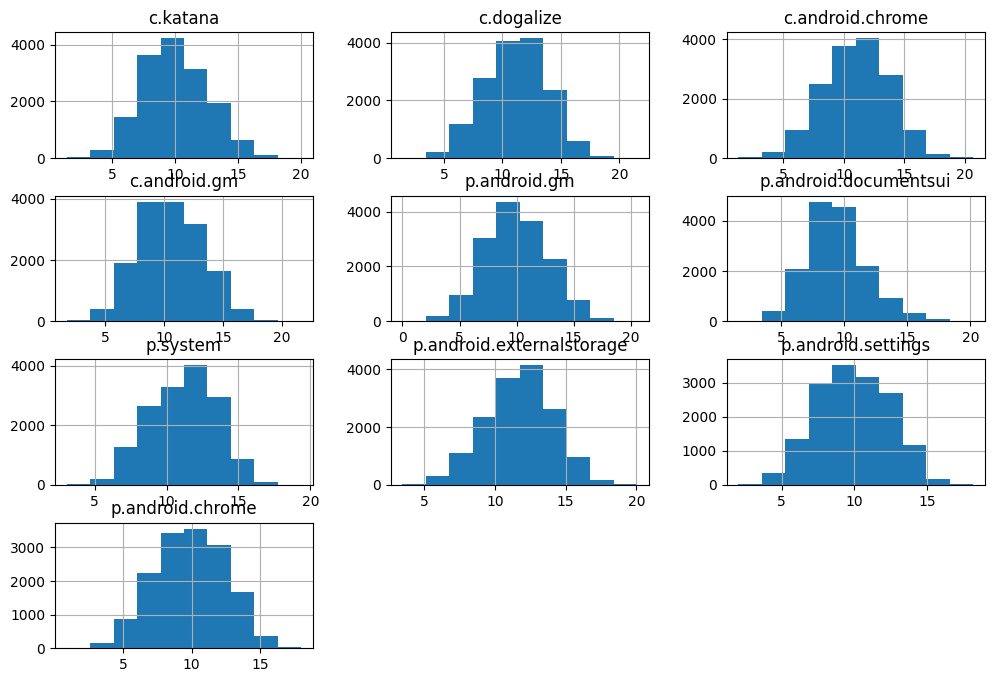

In [33]:
exclude_columns = ['mwra', 'imei','mwra_x', 'mwra_y']
df.hist(column=df.columns[~df.columns.isin(exclude_columns)], figsize=(12, 8))